### Open up Sagemaker Studio and use starter template

### Import packages

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
%matplotlib inline

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance

import warnings
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

import tensorflow as tf
from tensorflow import compat

warnings.filterwarnings("ignore", category=DeprecationWarning)

### Setup Kaggle API Key

In [3]:
!pip install --q kaggle 

In [4]:
!touch ~/.kaggle/kaggle.json
kaggle_api_token = {"username":"arnitpanda","key":"7bf8ecd031d63602078228abfcfbd10f"}

In [5]:
import json 

# Writes API Credentials to Kaggle file
with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(kaggle_api_token,file)

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
# Information regarding datatypes of variables within the train 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [10]:
# Check for null values in train data
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

***-: No missing values in the train dataset.***

In [11]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
# Check for null values in test data
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

***-: No missing values in the test dataset.***

In [13]:
# Shape of train and test datasets
print("Train Dataset Shape : ", train.shape)
print("Test Dataset Shape  : ", test.shape)

Train Dataset Shape :  (10886, 12)
Test Dataset Shape  :  (6493, 9)


***-: Some features are missing in the test dataset.***

In [14]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [15]:
# Checking all the features and target variable in the dataset
print("Columns in Train Dataset:\n", train.columns)
print("\nColumns in Test Dataset:\n", test.columns)

Columns in Train Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Columns in Test Dataset:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [16]:
# Variables not present in test dataset
print("Variables that are not present in the test dataset: ")
list(set(train.columns).difference(set(test.columns)))

Variables that are not present in the test dataset: 


['count', 'registered', 'casual']

***-: Here, `count` is the predicted(dependent) varibale whereas the other two `casual` and `registered` aren't present in the test dataset.***

### *A short description of the Features*  
`datetime` - hourly date + timestamp  
`season` - 1 = spring, 2 = summer, 3 = fall, 4 = winter  
`holiday` - whether the day is a holiday/not  
`workingday` - whether the day is neither a weekend nor holiday  
`weather` - 
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

`temp` - temperature in Celsius  
`atemp` - "feels like" temperature in Celsius  
`humidity` - relative humidity  
`windspeed` - wind speed  
`casual` - number of non-registered user rentals initiated  
`registered` - number of registered user rentals initiated  
`count` - number of total rentals

### Exploratory Data Analysis and Creating additional features

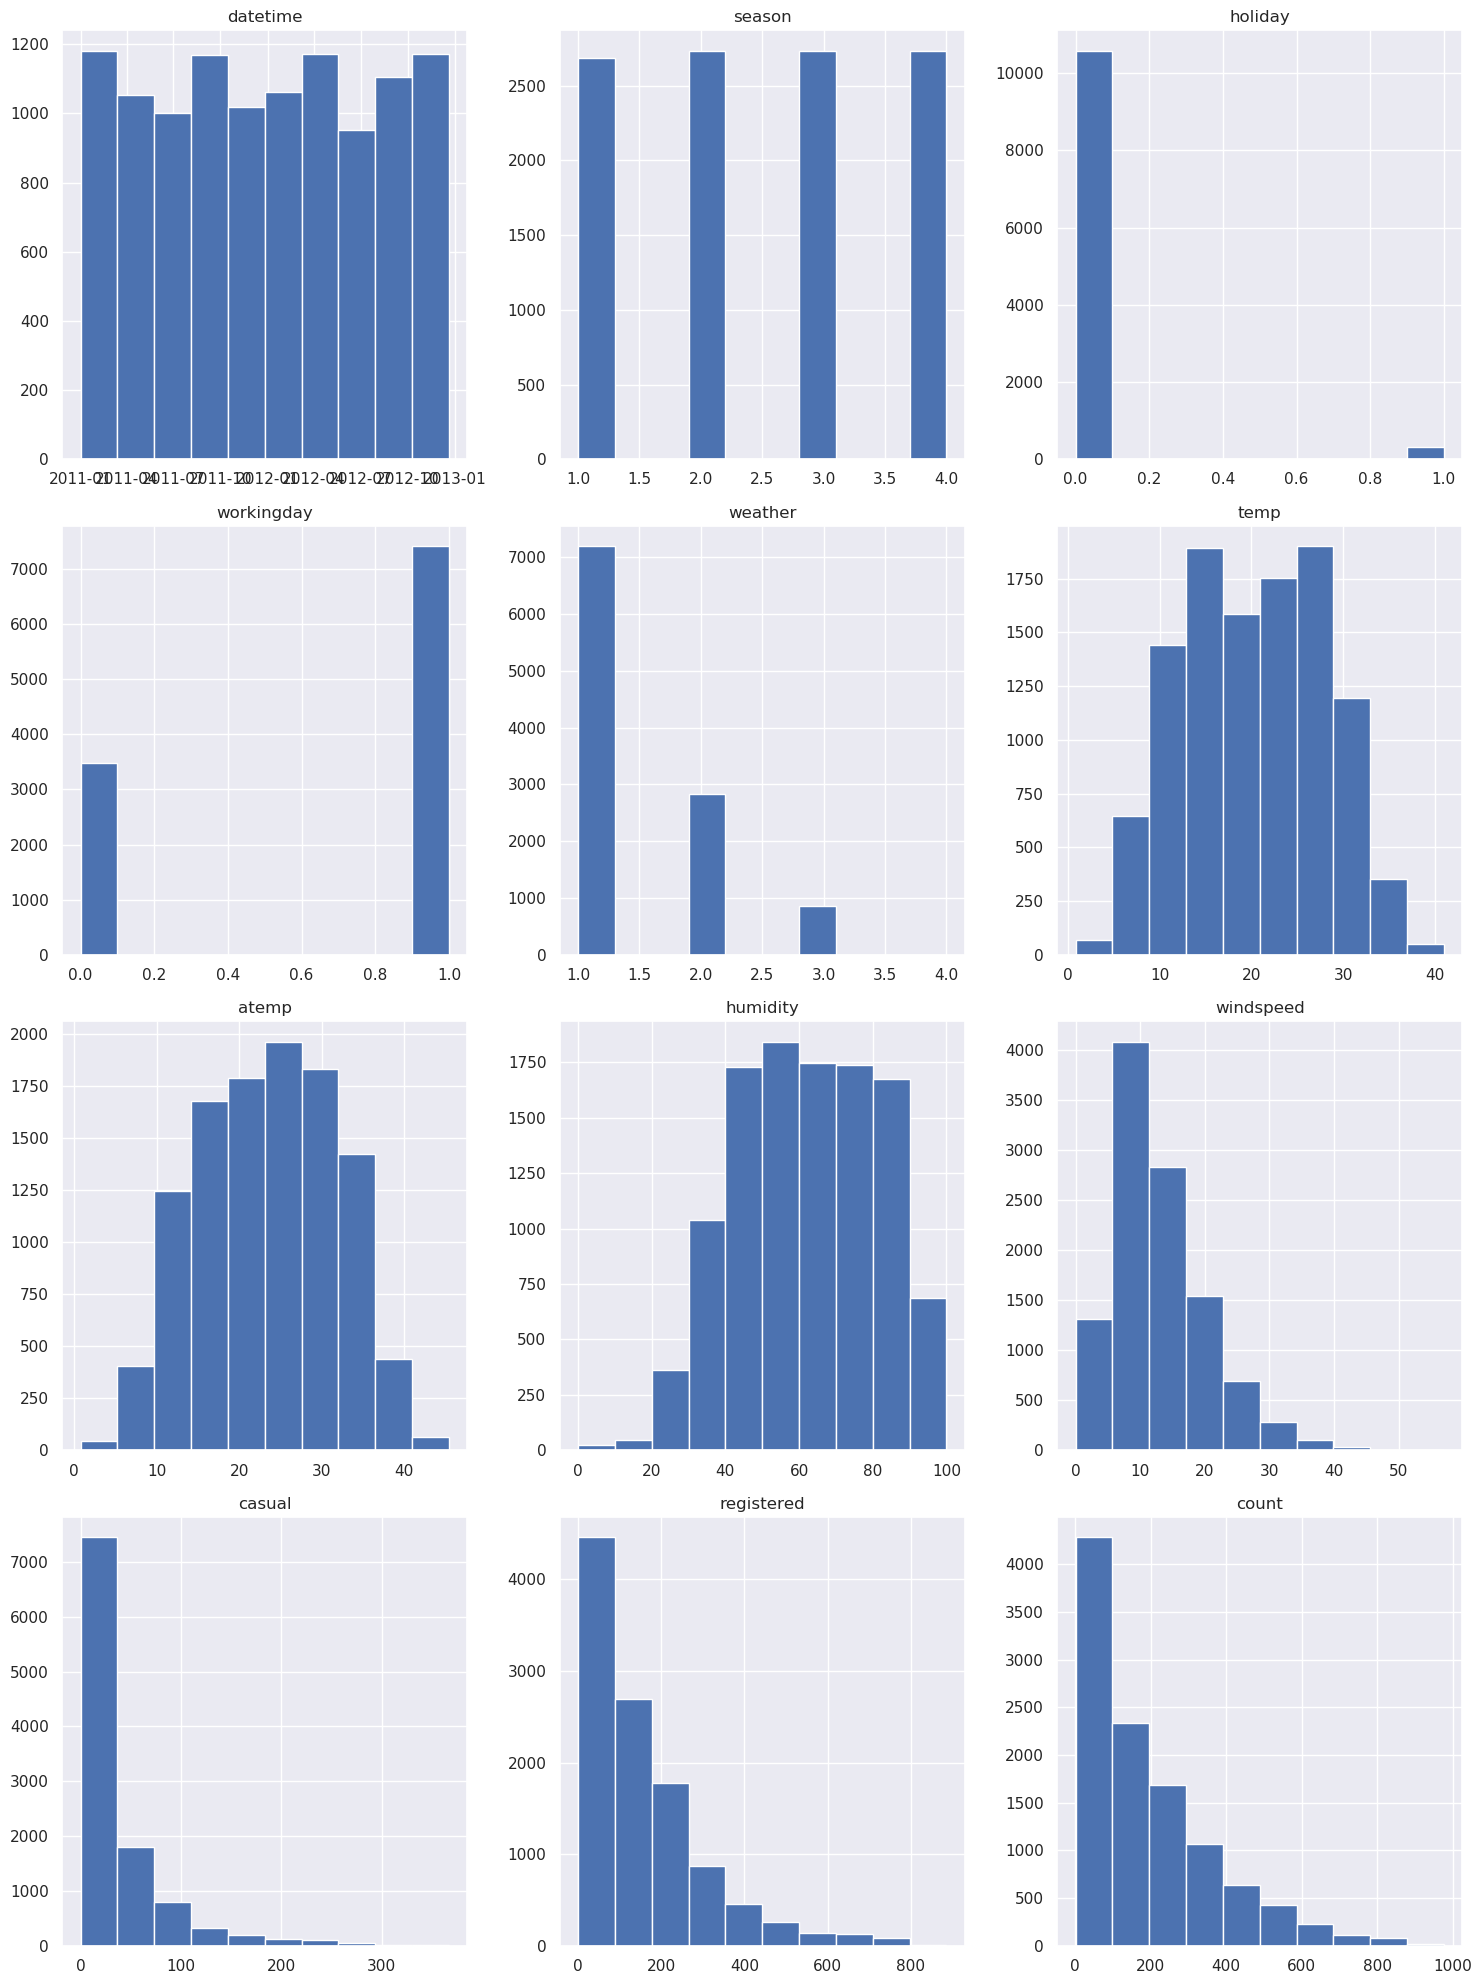

In [17]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

***1. `season` and `weather` features are likely to be categorical features from the plot  
2. `holiday` and `workingday` features are one-hot encoded columns with 0 and 1  
3. `temp`, `atemp` and `humidity` features depicts normal distribution***

### Plot Heatmap using Correlation Matrix

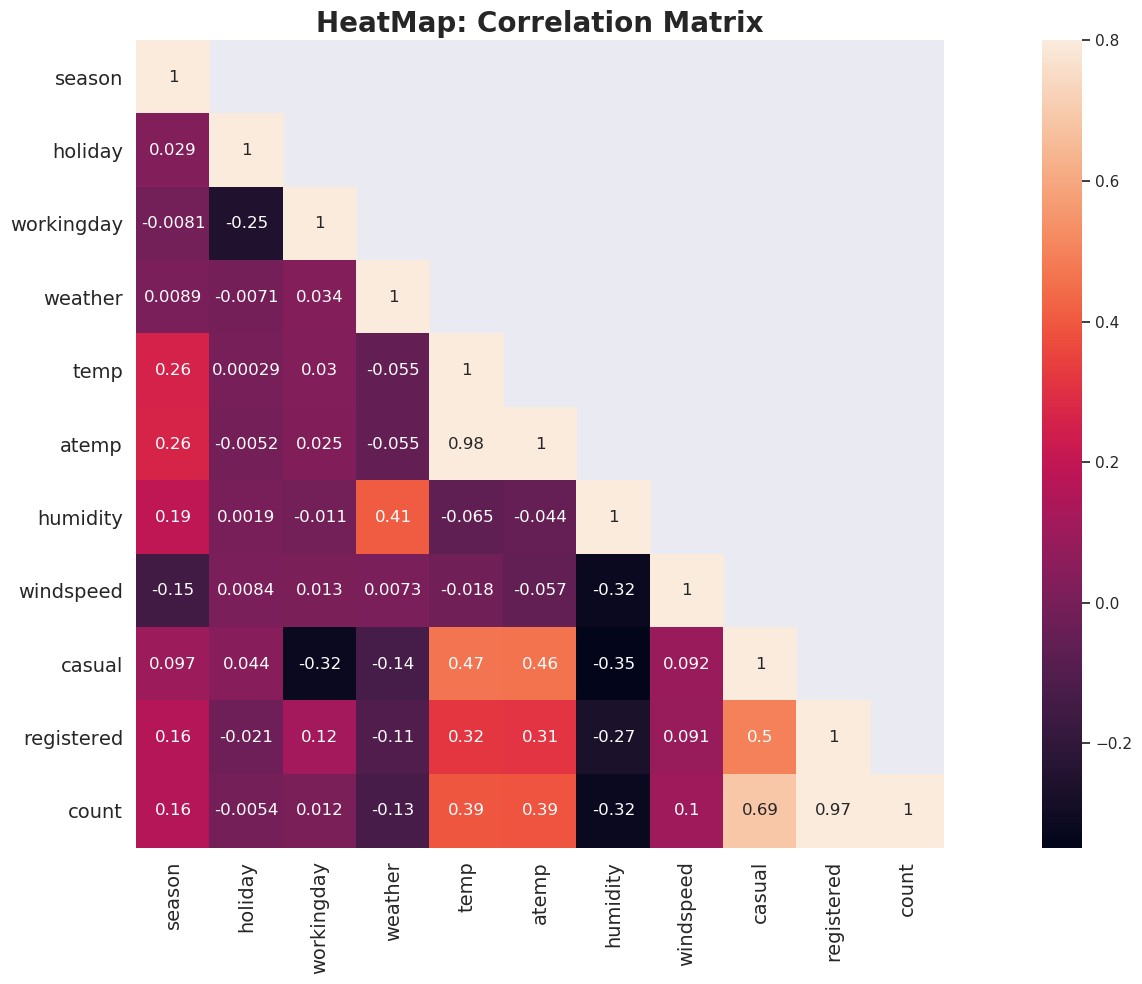

In [18]:
corrMatt = train[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, annot=True)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

***1. `temp` and `atemp` features are highly correlated with a positive correlation of 0.97  
2. `casual` and `registered` are also highly correlated to the target- `count`  
3. `holiday` and `workingday` show the leat correlation with `count` feature  
4. `weather` and `humidity` is slightly negatively correlated   
5. `humidity` is inversely related to count as expected as the weather is humid people will not like to travel on a bike.  
6. Also note that `weather` and `count` are highly inversely related. This is bcoz for uour data as weather increases from (1 to 4) implies that weather is getting more worse and so lesser people will rent bikes.  
7. registered/casual and count are highly related which indicates that most of the bikes that are rented are registered.***  

### Creating New Features

In [19]:
x_date = test['datetime'].values

In [20]:
# Checking 'datetime' feature in train data
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

***Variation is seen on hourly basis. So splitting the `datetime` feature into year, month, day (dayofweek) and hour respectively.***

In [21]:
# Splitting the 'datetime' feature in train data
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1})
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,0


In [22]:
# Splitting the 'datetime' feature in test data
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0


In [23]:
# now can drop datetime column.
train.drop('datetime',axis=1,inplace=True)
test.drop('datetime',axis=1,inplace=True)

In [24]:
# Recheck datatype of features in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  hour        10886 non-null  int64  
 12  day         10886 non-null  int64  
 13  month       10886 non-null  int64  
 14  year        10886 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 1.2 MB


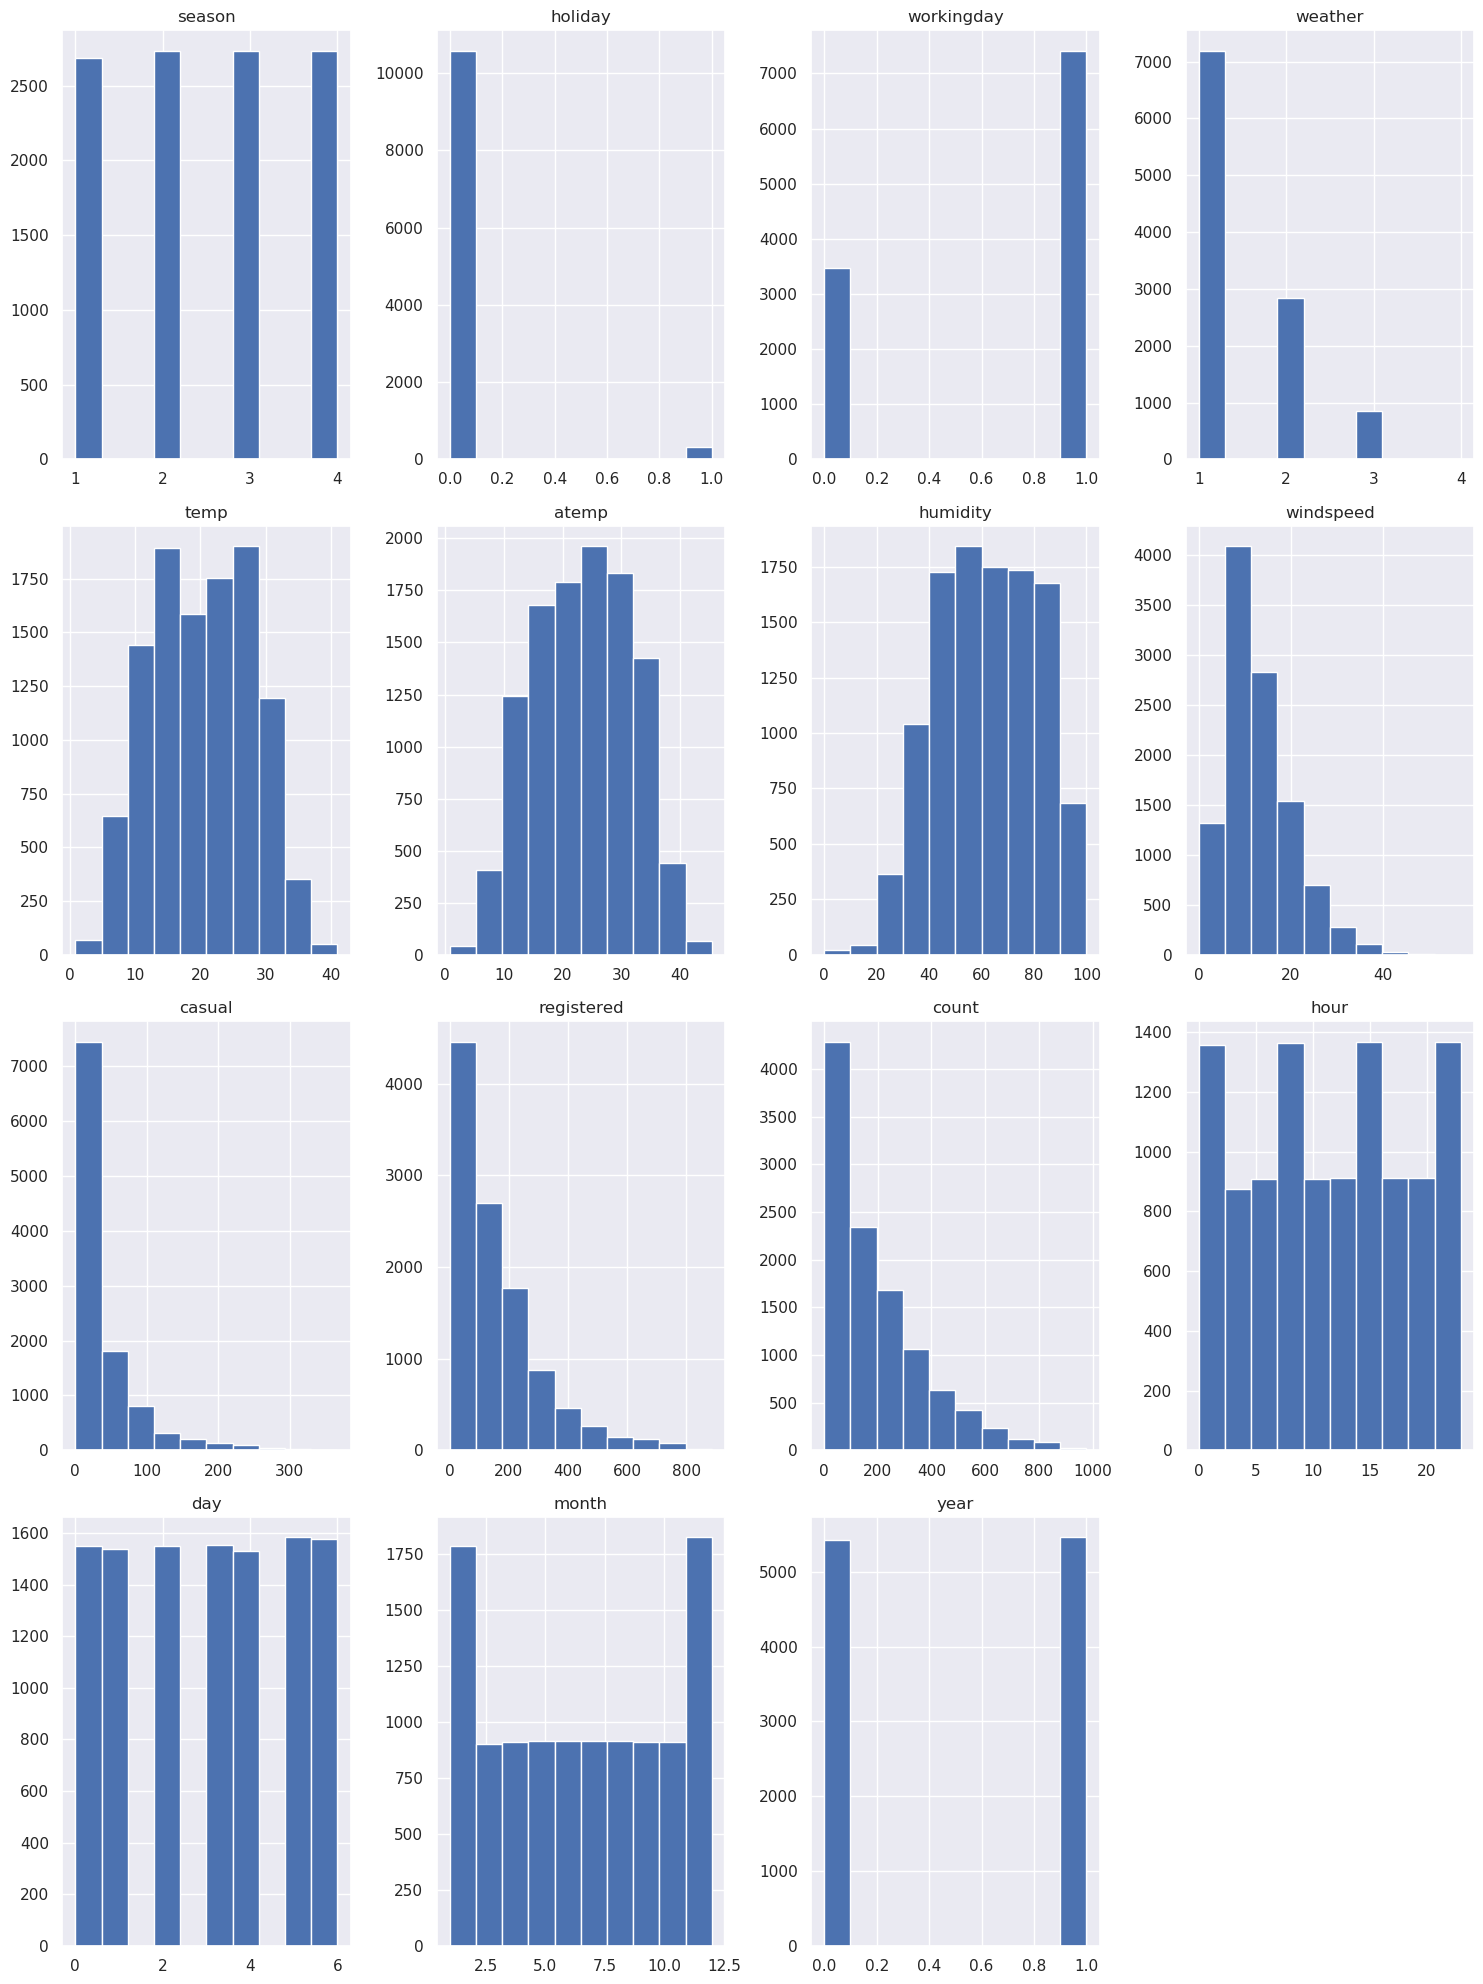

In [25]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))
plt.tight_layout()
plt.show()

### Outliers Analysis

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

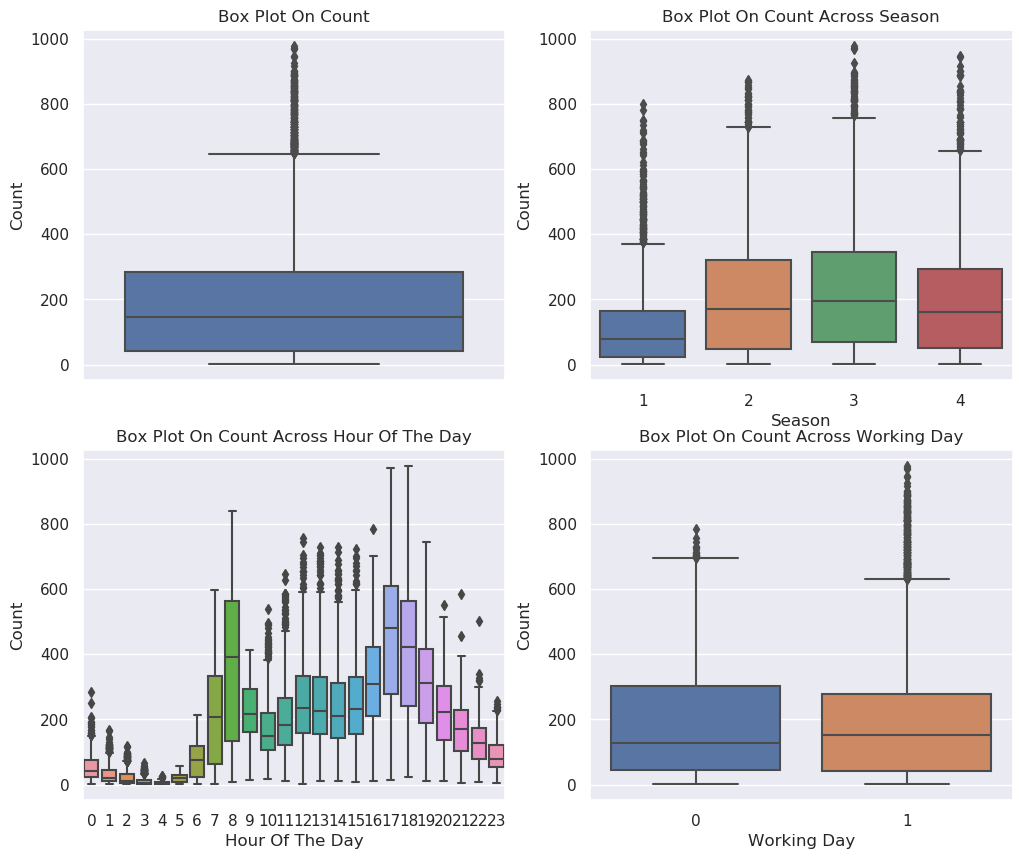

In [26]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

***1. At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).  
2. Season-1 has got relatively lower count.The dip in median value in boxplot gives evidence for it.  
3. The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.  
4. Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day".***

In [27]:
def delete_outliers(data, df):
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers=np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    print("Have already deleted",outliers_num,"outliers")
    print ("Shape Before Delete Ouliers: ",original_shape)
    print ("Shape After Delete Ouliers: ",df.shape)

In [28]:
delete_outliers(train['count'], train)

Have already deleted 147 outliers
Shape Before Delete Ouliers:  (10886, 15)
Shape After Delete Ouliers:  (10739, 15)


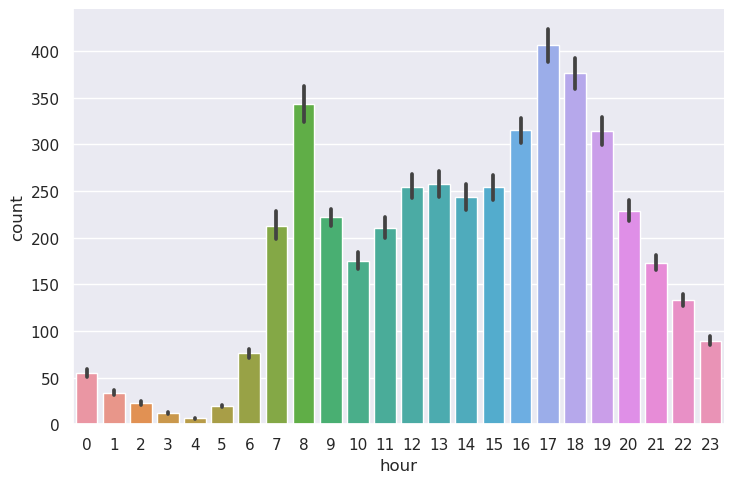

In [29]:
# Variation in`count` w.r.t `hour`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="hour",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.show()

***Frequency of Bike Rides (Hourly-basis):***
* `High`: From 7-9 (7am - 9am) and 16-19 (4pm - 7pm)  
* `Moderate`: 10-15 (10am - 3pm)
* `Low`: Low: 0-6 (12am - 6am) and 20-24 (8pm - 12am)  
  
  ***This makes sense as most people who rent these bikes could potentially be young college students or working professionals, who actively commute via some means of transport during peak hours of the day mentioned under the `High` category.***

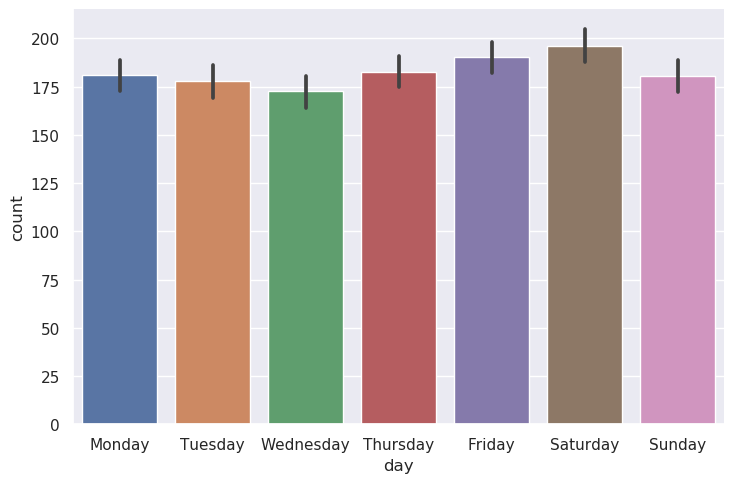

In [30]:
# Variation in`count` w.r.t `day` (dayofweek) [0: Monday -> 6: Sunday]

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="day",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.xticks(ticks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", 
                                     "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

***Not much variation or pattern is seen in the bike rental counts with respect to featureday.***

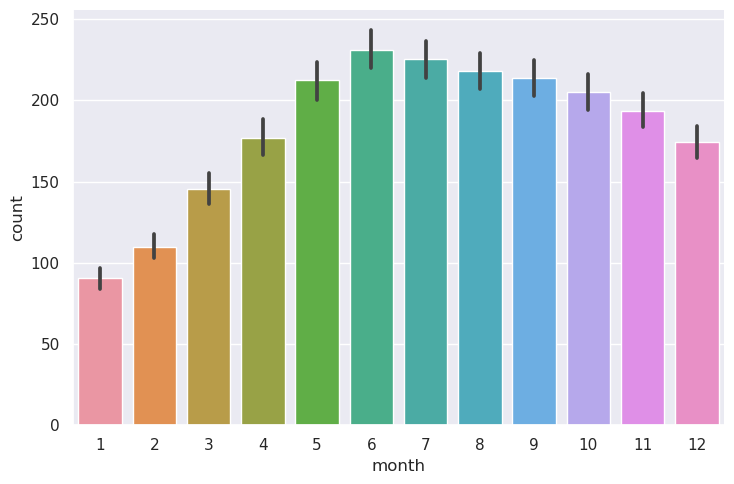

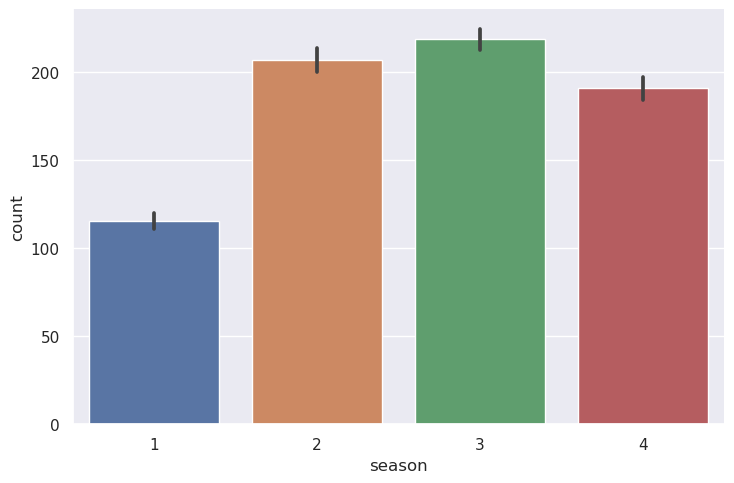

In [31]:
# Variation in`count` w.r.t `month` and 'season'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="month",y="count",data=train,kind='bar',height=5,aspect=1.5) 
sn.catplot(x="season",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

***Since seasons show variation in the number of bike rentals count, it is obvious to notice the same from the month feature, but at a slightly more granular level.***

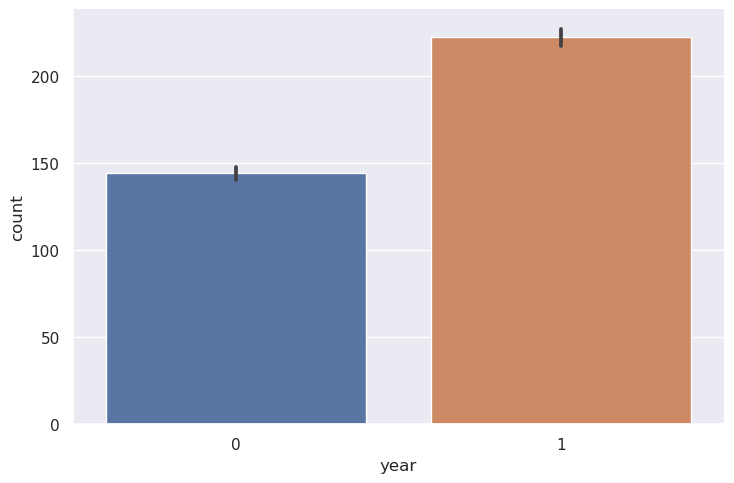

In [32]:
# Variation in`count` w.r.t `year`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="year",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

***Year 2012 has higher bike demand as compared to 2011.***

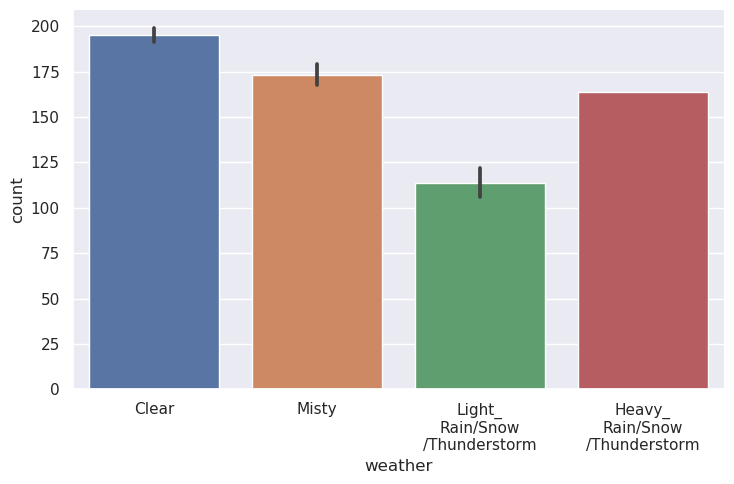

In [33]:
# Variation in`count` w.r.t `weather'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="weather",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.xticks(ticks=range(0,4), labels=["Clear","Misty", 
                                     "Light_\nRain/Snow\n/Thunderstorm", 
                                     "Heavy_\nRain/Snow\n/Thunderstorm"])
plt.tight_layout()
plt.show()

***Bike rental counts are highest in Clear weather, followed by Misty weather.***

Text(0, 0.5, 'Count')

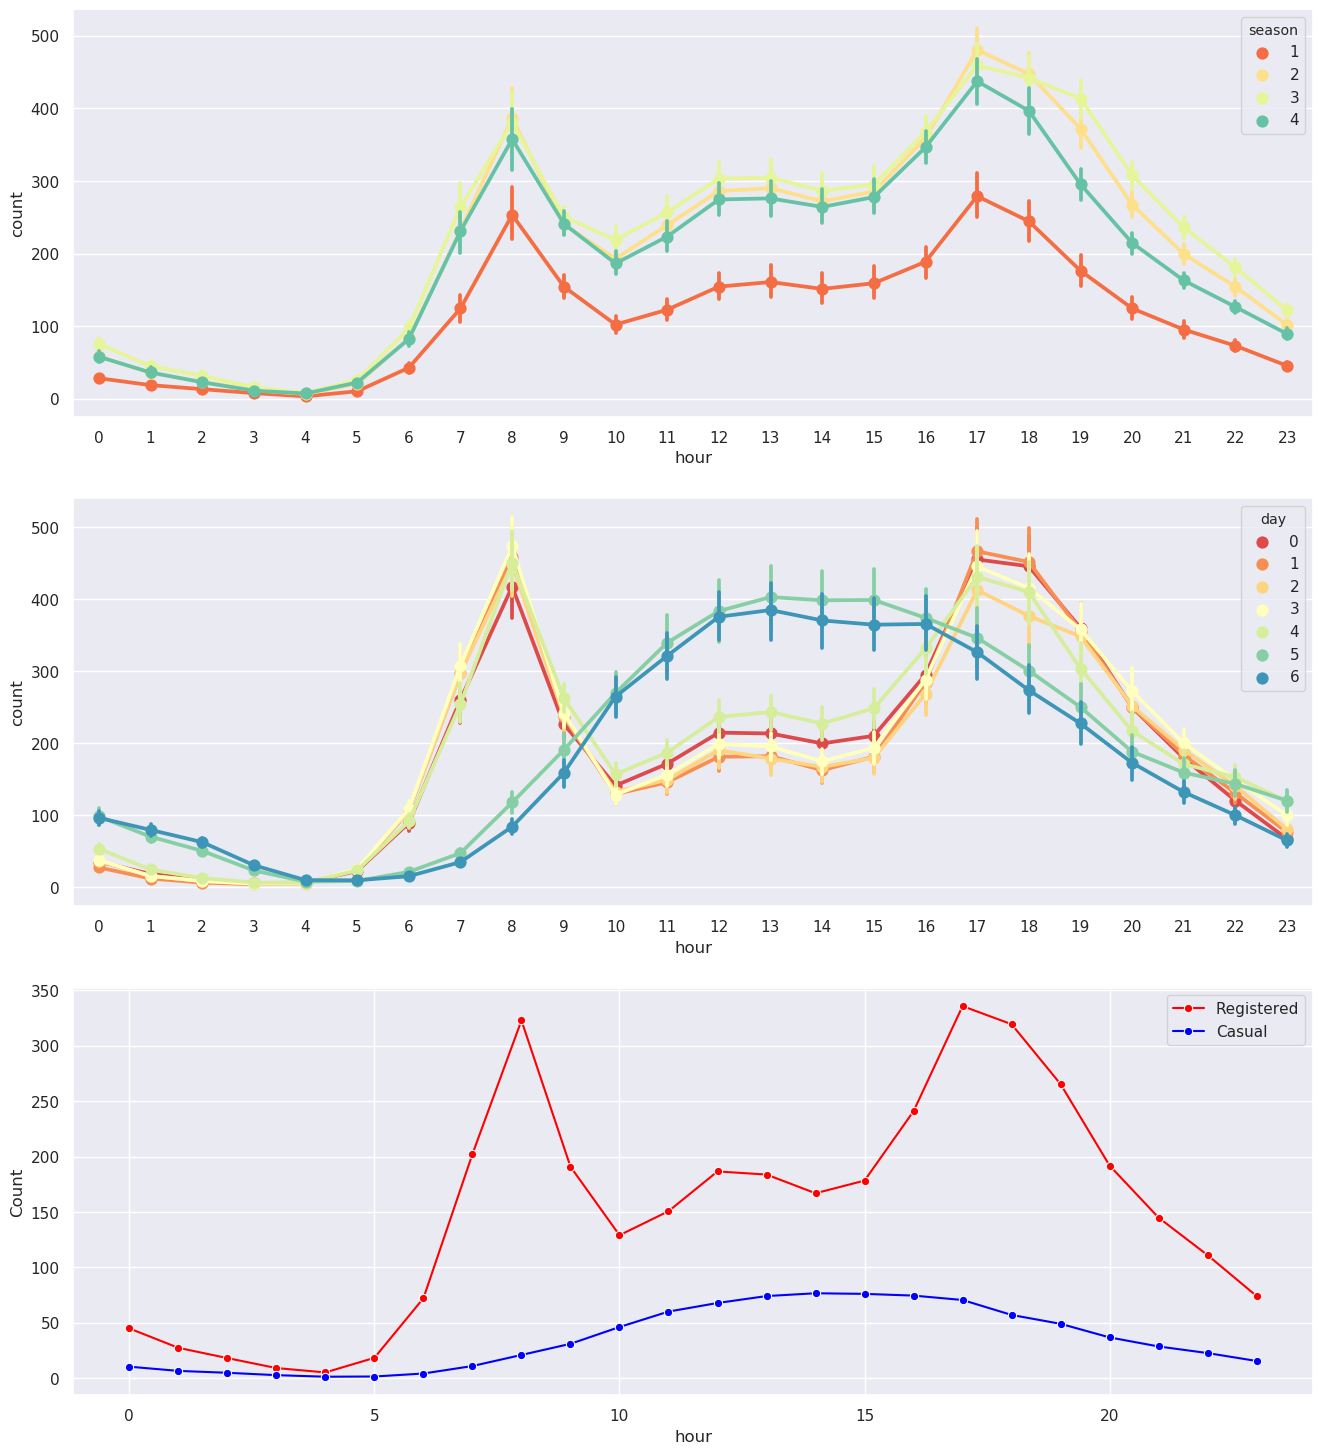

In [34]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(16,18)
sn.pointplot(x='hour',y='count',hue='season',join=True, data=train, palette="Spectral", ax=ax1)
sn.pointplot(x='hour',y='count',hue='day',join=True, data=train, palette="Spectral", ax=ax2)
sn.lineplot(x='hour', y='registered', data=train, color='red',label='Registered', marker='o', ax=ax3, ci=None)
sn.lineplot(x='hour', y='casual', data=train, color='blue', label='Casual', marker='o', ax=ax3, ci=None)
ax3.set_ylabel('Count')

* It is observed that many people, regardless of their registration status, tend to rent bicycles between 10AM and 4PM. This trend is likely due to the fact that people are more likely to use bicycles for leisure activities during this time of the day.

* Furthermore, it is also found that most un-registered users tend to rent bicycles around 10am-3pm on weekends. This could be because casual users may use other forms of transportation to go to work/school during the weekdays and only rent bicycles during weekends for recreational activities.

* On weekdays, the peak rental count around 7AM-8AM and 5PM-6PM is primarily contributed by registered users. As previously mentioned, this can be attributed to regular school and office commuters who rely on bicycles as their primary mode of transportation during these times.

In [35]:
# Seperating season as per values. this is bcoz this will enhance features.
season=pd.get_dummies(train['season'],prefix='season')
train=pd.concat([train,season],axis=1)
train.head()
season=pd.get_dummies(test['season'],prefix='season')
test=pd.concat([test,season],axis=1)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4
0,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0


In [36]:
# Same for weather. this is bcoz this will enhance features.
weather=pd.get_dummies(train['weather'],prefix='weather')
train=pd.concat([train,weather],axis=1)
train.head()
weather=pd.get_dummies(test['weather'],prefix='weather')
test=pd.concat([test,weather],axis=1)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0,1,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0,1,0,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0,1,0,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0,1,0,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0,1,0,0,0


In [37]:
# Now can drop weather and season.
train.drop(['season','weather'],inplace=True,axis=1)
train.head()
test.drop(['season','weather'],inplace=True,axis=1)
test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0,1,0,0,0
1,0,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0,1,0,0,0
2,0,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0,1,0,0,0
3,0,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0,1,0,0,0
4,0,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0,1,0,0,0


In [38]:
# # Dropping the independent features as they're not present in the test dataset
# train_df = train.drop(['casual','registered'],axis=1,inplace=True)

In [39]:
train.columns.to_series().groupby(train.dtypes).groups

{uint8: ['season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4'], int64: ['holiday', 'workingday', 'humidity', 'casual', 'registered', 'count', 'hour', 'day', 'month', 'year'], float64: ['temp', 'atemp', 'windspeed']}

In [40]:
train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,hour,...,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,0,9.84,14.395,81,0.0,3,13,16,0,...,1,0,1,0,0,0,1,0,0,0
1,0,0,9.02,13.635,80,0.0,8,32,40,1,...,1,0,1,0,0,0,1,0,0,0
2,0,0,9.02,13.635,80,0.0,5,27,32,2,...,1,0,1,0,0,0,1,0,0,0
3,0,0,9.84,14.395,75,0.0,3,10,13,3,...,1,0,1,0,0,0,1,0,0,0
4,0,0,9.84,14.395,75,0.0,0,1,1,4,...,1,0,1,0,0,0,1,0,0,0


In [41]:
# Statistics of all features within the trian data
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,hour,...,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,...,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.00000,10739.000000,10739.000000
mean,0.028960,0.676786,20.130507,23.548846,62.049632,12.787706,35.220039,147.783779,183.003818,11.479281,...,6.505354,0.495111,0.249744,0.250861,0.248068,0.251327,0.658907,0.26157,0.079430,0.000093
std,0.167702,0.467726,7.777571,8.463179,19.241364,8.171075,49.546882,136.370597,166.681429,6.931510,...,3.456491,0.499999,0.432885,0.433529,0.431911,0.433796,0.474099,0.43951,0.270421,0.009650
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,41.000000,6.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,1.000000,20.500000,24.240000,62.000000,12.998000,16.000000,116.000000,141.000000,11.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
75%,0.000000,1.000000,26.240000,31.060000,78.000000,16.997900,47.000000,217.000000,276.000000,17.000000,...,10.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,367.000000,712.000000,734.000000,23.000000,...,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [42]:
# Dropping highly correlated independent feature 'atemp' from train and test datasets
train.drop(["atemp"], axis=1, inplace=True)
test.drop(["atemp"], axis=1, inplace=True)

In [43]:
# Checking datatypes of variables
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10739 non-null  int64  
 1   workingday  10739 non-null  int64  
 2   temp        10739 non-null  float64
 3   humidity    10739 non-null  int64  
 4   windspeed   10739 non-null  float64
 5   casual      10739 non-null  int64  
 6   registered  10739 non-null  int64  
 7   count       10739 non-null  int64  
 8   hour        10739 non-null  int64  
 9   day         10739 non-null  int64  
 10  month       10739 non-null  int64  
 11  year        10739 non-null  int64  
 12  season_1    10739 non-null  uint8  
 13  season_2    10739 non-null  uint8  
 14  season_3    10739 non-null  uint8  
 15  season_4    10739 non-null  uint8  
 16  weather_1   10739 non-null  uint8  
 17  weather_2   10739 non-null  uint8  
 18  weather_3   10739 non-null  uint8  
 19  weather_4   10739 non-nul

In [44]:
rf_columns = [
    'weather_1', 'weather_2', 'weather_3', 'weather_4', 'temp', 'windspeed',
    'workingday', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday',
    'hour',
]
gb_columns =[
    'weather_1', 'weather_2', 'weather_3', 'weather_4', 'temp', 'humidity', 'windspeed',
    'workingday', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday',
    'hour','year', 
]

In [45]:
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

In [46]:
y_casual=train['casual'].apply(lambda x: np.log1p(x)).values
y_registered=train['registered'].apply(lambda x: np.log1p(x)).values
y=train['count'].apply(lambda x: np.log1p(x)).values

In [47]:
print("(After EDA + Feature Engineering) Train Data Shape : ", train.shape)
print("(After EDA + Feature Engineering) Test Data Shape  : ", test.shape)

(After EDA + Feature Engineering) Train Data Shape :  (10739, 20)
(After EDA + Feature Engineering) Test Data Shape  :  (6493, 17)


### XGBoost

In [50]:
# XGBoost
xgb_params = {'random_state': 42, 
              'n_estimators': 200, 
              'max_depth': 5, 
              'learning_rate': 0.1}

XGB1 = xgb.XGBRegressor(**xgb_params)
XGB1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",XGB1.score(gb_x_train,y_casual))

XGB2 = xgb.XGBRegressor(**xgb_params)
XGB2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",XGB2.score(gb_x_train,y_registered))

XGB3 = xgb.XGBRegressor(**xgb_params)
XGB3.fit(gb_x_train,y)
print("model score for prediting count:",XGB3.score(gb_x_train,y))

model score for prediting casual count: 0.9155841423397277
model score for prediting registered count: 0.9629298485997685
model score for prediting count: 0.952443803341932


<Figure size 1500x1200 with 0 Axes>

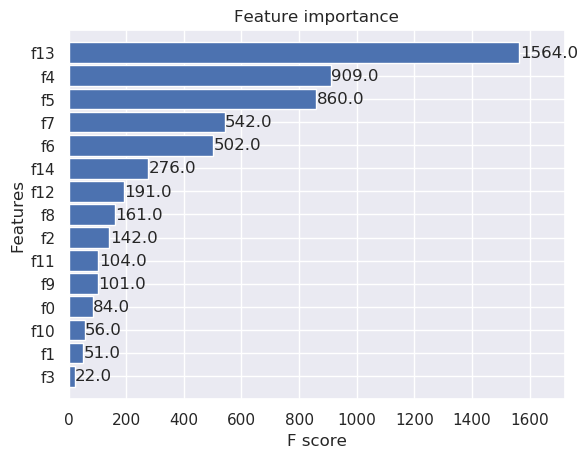

In [51]:
from xgboost import plot_importance, plot_tree
fig = plt.figure(figsize=(15,12))
fig = plot_importance(XGB3, height=0.9,max_num_features = 25)
plt.show()

In [52]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])

In [53]:
pred_xgb

array([ 10.262078 ,   4.48667  ,   2.2565615, ..., 105.56177  ,
        86.265976 ,  52.68291  ], dtype=float32)

In [54]:
submit = pd.DataFrame({'datetime':x_date,'count':pred_xgb})
submit.to_csv('submission-XGB.csv',index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission-XGB.csv -m "XGB submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 435kB/s]
Successfully submitted to Bike Sharing Demand

In [56]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission-XGB.csv           2023-05-26 15:09:18  XGB submission                     complete  0.38604      0.38604       
submission_neunet.csv        2023-05-26 14:37:30                                     complete  0.49668      0.49668       
submisssion-RForReg-3.csv    2023-05-26 14:36:58                                     complete  0.47767      0.47767       
submisssion-XGB-2.csv        2023-05-26 14:36:19                                     complete  0.38604      0.38604       
tail: write error: Broken pipe


#### New Score of `0.38604`

### Random Forest Regression

In [57]:
train.drop(['casual','registered'],axis=1,inplace=True)

In [58]:
x_train,x_test,y_train,y_test=train_test_split(train.drop('count',axis=1),train['count'],test_size=0.25,random_state=42)

In [59]:
#for random forest regresion.
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.318085094229231


In [60]:
clf_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [61]:
pred_f=clf_rf.predict(test)

In [62]:
pred_f

array([ 12.384,   5.198,   2.862, ..., 161.096, 107.088,  68.762])

In [63]:
pred_f.shape

(6493,)

In [64]:
type(pred_f)

numpy.ndarray

In [65]:
submit = pd.DataFrame({'datetime':x_date,'count':pred_f})
submit.to_csv('submission-RandomForest.csv',index=False)

In [66]:
!kaggle competitions submit -c bike-sharing-demand -f submission-RandomForest.csv -m "RandomForest submission"

100%|█████████████████████████████████████████| 174k/174k [00:00<00:00, 347kB/s]
Successfully submitted to Bike Sharing Demand

In [67]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission-RandomForest.csv  2023-05-26 15:11:09  RandomForest submission            complete  0.47553      0.47553       
submission-XGB.csv           2023-05-26 15:09:18  XGB submission                     complete  0.38604      0.38604       
submission_neunet.csv        2023-05-26 14:37:30                                     complete  0.49668      0.49668       
submisssion-RForReg-3.csv    2023-05-26 14:36:58                                     complete  0.47767      0.47767       
tail: write error: Broken pipe


#### New Score of `0.47553`

## Neural Network

In [68]:
# Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=1,activation="linear"))

In [69]:
# Compile the model with a mean squared error loss function and L2 regularization
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [70]:
# Train the model on the train data
history = model.fit(x_train, y_train, epochs=200, verbose = 0)

In [71]:
# Predict the values of y for the test data
y_pred = model.predict(x_test)
print("Predicted y values:", y_pred)

84/84 [==============================] - 0s 1ms/step
Predicted y values: [[132.99771]
 [ 42.43634]
 [332.76984]
 ...
 [269.6574 ]
 [136.20149]
 [172.4952 ]]


In [72]:
pred_nn = model.predict(test)

203/203 [==============================] - 0s 1ms/step


In [73]:
submit = pd.DataFrame(pred_nn)
submit.to_csv('submission-NN.csv',index=False)

In [74]:
df2 = pd.read_csv("submission-NN.csv")
df2.columns = ["count"]
df2.head()

,count
0,11.557147
1,4.850537
2,3.323827
3,2.536149
4,2.604533


In [75]:
submission_neunet = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_neunet["count"] = df2["count"]
submission_neunet.to_csv("submission_NeuralNet.csv", index=False)

In [76]:
!kaggle competitions submit -c bike-sharing-demand -f submission_NeuralNet.csv -m "NeuralNet submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 418kB/s]
Successfully submitted to Bike Sharing Demand

In [77]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_NeuralNet.csv     2023-05-26 15:13:26  NeuralNet submission               complete  0.50491      0.50491       
submission-RandomForest.csv  2023-05-26 15:11:09  RandomForest submission            complete  0.47553      0.47553       
submission-XGB.csv           2023-05-26 15:09:18  XGB submission                     complete  0.38604      0.38604       
submission_neunet.csv        2023-05-26 14:37:30                                     complete  0.49668      0.49668       
tail: write error: Broken pipe


#### New Score of `0.50491`

### Model Comparison

In [80]:
df = pd.DataFrame([
    ['baseline', 'autogluon', 1.79438],
    ['add_features', 'autogluon', 0.53813],
    ['hyperparam', 'autogluon', 0.53854],
    ['hyperparam', 'xgboost', 0.38604],
    ['hyperparam', 'random forest regression', 0.47553],
    ['hyperparam', 'neural network', 0.50491]
],
    columns=['iteration', 'model', 'submission_rmsle'])
df

,iteration,model,submission_rmsle
0,baseline,autogluon,1.79438
1,add_features,autogluon,0.53813
2,hyperparam,autogluon,0.53854
3,hyperparam,xgboost,0.38604
4,hyperparam,random forest regression,0.47553
5,hyperparam,neural network,0.50491


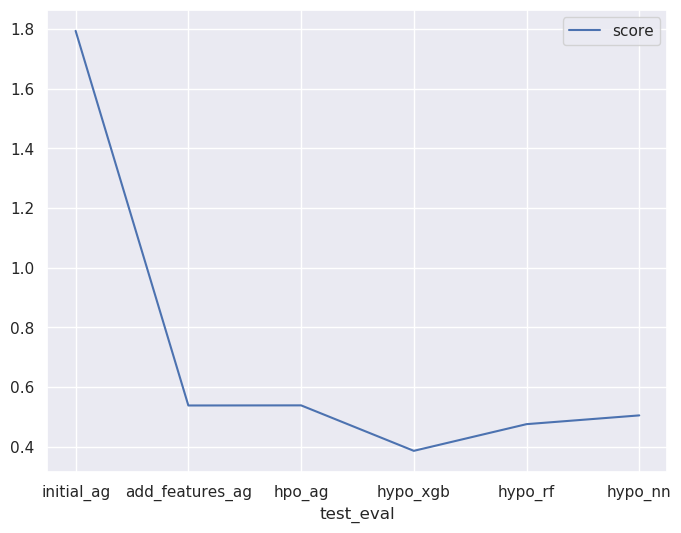

In [81]:
fig = pd.DataFrame(
    {
        "test_eval": ["initial_ag", "add_features_ag", "hpo_ag", "hypo_xgb", "hypo_rf", "hypo_nn"],
        "score": [1.79438, 0.53813, 0.53854, 0.38604, 0.47553, 0.50491]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('diff_models_test_score.png')

## Conclusion:

The top-ranked model was the (`added features`) **`XGBoost`** model with `hyperparameters`, with the best Kaggle score of **`0.38604`** (on test dataset).